In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, GRU, Dropout
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from tensorflow.keras.optimizers import Adam
from sklearn.linear_model import Lasso

# Read data
df = pd.read_csv('data.csv')
# 쓸데없는 index 제거
df = df.drop(df.columns[0], axis=1)
#print(df.head())

train_hours = pd.to_datetime(df['_time'])
#print(train_hours.tail(15))

# moduleName = cosmos만 고르기
cosmos_df = df[df['chainName'] == "cosmos"]
#columns_to_keep = ['_time', 'cap', 'high24h', 'low24h', 'price','totalVolume', 'apr', 'bondedTokens', 'communityTokens', 'tps', 'priceBTC', 'Binance #01 (Deposit)-amountValue', 'Binance #02 (Deposit)-amountValue', 'Binance #03 (Withdraw)-amountValue', 'Binance #04 (Staking)-amountValue', 'Bitforex #01 (Deposit)-amountValue', 'Bithumb #02 (Withdraw)-amountValue', 'Bithumb #03-amountValue', 'Bithumb #05-amountValue', 'Coinbase #01-amountValue', 'Coinbase #03-amountValue', 'Coinbase #05-amountValue', 'Coinbase #06-amountValue', 'Coinbase #08-amountValue', 'Coinone #01(Deposit)-amountValue', 'Digfinex #01 (Deposit)-amountValue', 'DokiaCapital #01 (Validator)-amountValue', 'DokiaCapital #02 (Validator)-amountValue', 'HitBTC #02-amountValue', 'Ignite-amountValue', 'Interchain Foundation #01-amountValue', 'Interchain Foundation #02-amountValue', 'Kraken #01-amountValue', 'MEXC #01 (Deposit)-amountValue', 'OKK #01-amountValue', 'Upbit #01 (Deposit)-amountValue', 'Upbit #02 (Withdraw)-amountValue', 'Upbit #10 (Validator)-amountValue', 'Upbit #11 (Staking)-amountValue', 'Upbit #12 (Staking)-amountValue', 'Upbit #13 (Staking)-amountValue', 'Upbit #14 (Staking)-amountValue', 'Upbit #15 (Staking)-amountValue', 'Upbit #16 (Staking)-amountValue', 'Upbit #17 (Staking)-amountValue', 'Upbit #18 (Staking)-amountValue', 'Upbit #19 (Staking)-amountValue', 'Upbit #20 (Staking)-amountValue', 'bonded_tokens_pool-amountValue', 'distribution-amountValue', 'fee_collector-amountValue', 'gov-amountValue', 'not_bonded_tokens_pool-amountValue']
cosmos_df = cosmos_df.drop(columns=['chainName', 'ath', 'athDate', 'atl', 'atlDate', 'JUNO ATOM Pool-amountValue', 'JUNO NETA Pool-amountValue', 'JUNO OSMO Pool-amountValue',	'JUNO RAW Pool-amountValue',	'JUNO ATOM Pool-boxplot',	'JUNO NETA Pool-boxplot',	'JUNO OSMO Pool-boxplot',	'JUNO RAW Pool-boxplot'])
print(cosmos_df.shape)
# (2446, 5)

(2446, 111)


In [11]:
# price col 위치 재조정.
cols = list(cosmos_df.columns)
cols.insert(1, cols.pop(cols.index('price')))
# Reindex the DataFrame
cosmos_df = cosmos_df.loc[:, cols]
#print(cosmos_df.head())

cols = list(cosmos_df)[1:cosmos_df.shape[1]]
print(cols)
print(cosmos_df.shape)

df_for_training = cosmos_df[cols].astype(float)
print(df_for_training.shape)

scaler = MaxAbsScaler()
scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)
print(df_for_training_scaled.shape)

# Lasso Regression for feature selection
lasso = Lasso(alpha=0.1)
lasso.fit(df_for_training_scaled, df_for_training_scaled)

# Use Lasso for feature selection
selected_features = np.where(lasso.coef_!=0)[0]

# Update your train data according to selected features
df_for_training_scaled_selected = df_for_training_scaled[:, selected_features]

['price', 'cap', 'capChange24h', 'capChangeRatio24H', 'capRank', 'change24h', 'changeRatio24H', 'high24h', 'low24h', 'priceChangePercentage14d', 'priceChangePercentage1H', 'priceChangePercentage1Y', 'priceChangePercentage24H', 'priceChangePercentage30D', 'priceChangePercentage7d', 'supplyCirculating', 'totalVolume', 'apr', 'blockTime', 'bondedTokens', 'communityTokens', 'inflation', 'tps', 'capBTC', 'priceBTC', 'priceChangePercentage1HBTC', 'totalVolumeBTC', 'Binance #01 (Deposit)-amountValue', 'Binance #02 (Deposit)-amountValue', 'Binance #03 (Withdraw)-amountValue', 'Binance #04 (Staking)-amountValue', 'Bitforex #01 (Deposit)-amountValue', 'Bithumb #02 (Withdraw)-amountValue', 'Bithumb #03-amountValue', 'Bithumb #05-amountValue', 'Coinbase #01-amountValue', 'Coinbase #03-amountValue', 'Coinbase #05-amountValue', 'Coinbase #06-amountValue', 'Coinbase #08-amountValue', 'Coinone #01(Deposit)-amountValue', 'Digfinex #01 (Deposit)-amountValue', 'DokiaCapital #01 (Validator)-amountValue', 

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


In [13]:
trainX = []
trainY = []

n_future = 1 
n_past = 24 

# define the point to split the data into training and testing
split_point = int(df_for_training_scaled_selected.shape[0]*0.8) 

# construct training part
for i in range(n_past, split_point):
    trainX.append(df_for_training_scaled_selected[i - n_past:i, 0:df_for_training_scaled_selected.shape[1]])
    trainY.append(df_for_training_scaled_selected[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

# construct testing part
testX = []
testY = []

for i in range(split_point, len(df_for_training_scaled_selected) - n_future +1):
    testX.append(df_for_training_scaled_selected[i - n_past:i, 0:df_for_training_scaled_selected.shape[1]])
    testY.append(df_for_training_scaled_selected[i + n_future - 1:i + n_future, 0])

testX, testY = np.array(testX), np.array(testY)

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

trainX shape == (1932, 24, 11).
trainY shape == (1932, 1).
testX shape == (490, 24, 11).
testY shape == (490, 1).


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 24, 32)            4320      
                                                                 
 dropout_2 (Dropout)         (None, 24, 32)            0         
                                                                 
 gru_3 (GRU)                 (None, 32)                6336      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 10689 (41.75 KB)
Trainable params: 10689 (41.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/80
73/73 [

INFO:tensorflow:Assets written to: ./models/GRU-v1/assets


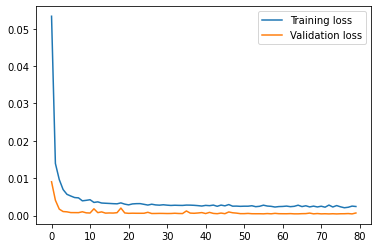

In [14]:
model = Sequential()
model.add(GRU(32, activation='tanh', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(32, activation='tanh', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

# fit the model
history = model.fit(trainX, trainY, epochs=(trainX.shape[0]//24), batch_size=24, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

# save the model to disk
model.save('./models/GRU-v1')

16/16 [==============================] - 0s 2ms/step


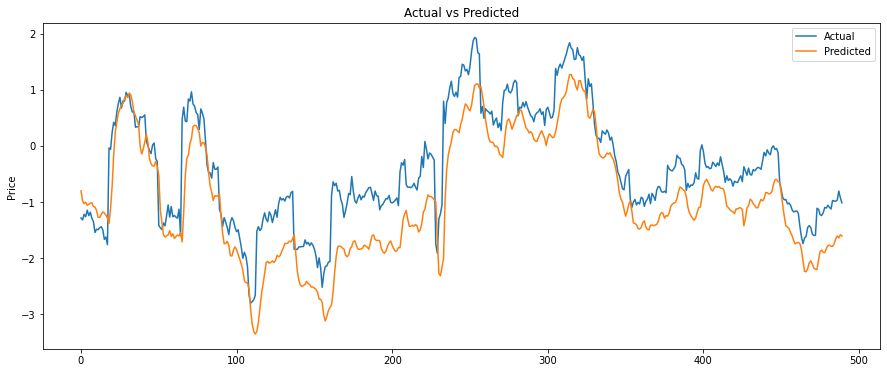

Test Score: 0.67 RMSE


In [15]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# load the model from disk
model = load_model('./models/GRU-v1')

def evaluate_model(model, X, y_true, scaler, df_for_training):
    # Predict
    y_pred = model.predict(X)
    
    # Create dummy arrays for inverse transform
    dummy_pred = np.zeros((len(y_pred), df_for_training.shape[1]))
    dummy_true = np.zeros((len(y_true), df_for_training.shape[1]))
    
    # Replace the first column with predicted and actual values
    dummy_pred[:,0] = y_pred[:,0]
    dummy_true[:,0] = y_true[:,0]
    
    # Inverse transform
    y_pred_rescaled = scaler.inverse_transform(dummy_pred)[:,0]
    y_true_rescaled = scaler.inverse_transform(dummy_true)[:,0]
    
    # Calculate RMSE
    rmse = sqrt(mean_squared_error(y_true_rescaled, y_pred_rescaled))
    
    # Plot actual vs predicted values
    plt.figure(figsize=(15, 6))
    plt.plot(y_true_rescaled, label='Actual')
    plt.plot(y_pred_rescaled, label='Predicted')
    plt.title('Actual vs Predicted')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
    
    return rmse

# Call the function
# trainScore = evaluate_model(model, trainX, trainY, scaler, df_for_training)
# print('Train Score: %.2f RMSE' % (trainScore))

# Call the function for testing data
testScore = evaluate_model(model, testX, testY, scaler, df_for_training)
print('Test Score: %.2f RMSE' % (testScore))
